<a href="https://colab.research.google.com/github/zeiosis/ffnet-summary-prediction/blob/main/dangerzone/colab/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning
!pip install transformers

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
#from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [ ]:
df = pd.read_csv("fics_SMALL.csv")
df = df.drop(labels=['title', 'author', 'rating', 'category', 'fandom', 'relationship', 'character', 'language',\
               'published', 'status', 'status date', 'words', 'chapters', 'comments', 'kudos', 'bookmarks',\
                'hits', 'all_kudos', 'all_bookmarks'], axis=1)

for x in range(len(df)):
    df.at[x, 'body'] = df.at[x, 'body'][:1500]
df.at[4, 'body']
#df.loc[619]['additional tags']

'Venti was drunk. Drunk for the nth time and called out to the winds for the only one who could hear him. \n\nXiao dropped down gently behind the drunken bard, who sat at the top of the statue of Barbatos, hands reaching out in a cupped position.\n\n"You..." Xiao sighed, noting the way Venti leaned against the statue\'s hands as if it were a couch, and the ground was not a ways down. "Out of all places you could sober up, you chose here?"\n\n"Xiao! You\'re finally here!" Venti giggled. "What can I say, this is spot truly has one of the best views in all of Teyvat." He turned his head back to stare longingly at the giant tree in the middle of the plains outside Mondstadt, another comfort with another good view, Venti once said. "Despite the cold night breeze, being up here isn\'t quite bad. Though I would\'ve caught a cold if you didn\'t come as quick as you had."\n\nXiao replied with a grunt, walking up to the bard and picking him up bridal style with ease. Venti never struggled in his

In [ ]:
tagslist = df.loc[0]['additional tags'].split(", ")
tagsdict = {}
for x in range(620):
    tagslist = str(df.loc[x]['additional tags']).split(", ")
    for y in tagslist:
        try:
            tagsdict[y] += 1
        except:
            tagsdict[y] = 1
            
sdtaglist = []     

for x in tagsdict:
    t = [x]
    t.append(tagsdict[x])
    sdtaglist.append(t)
            
sdtaglist.sort(reverse=True, key=lambda a: a[1])

#sddict = dict(sdtaglist[:100])
#print(sddict)
#print(sdtaglist)

f1 = {"tags": [], "count": []}
for x in sdtaglist[:100]:
    f1['tags'].append(x[0])
    f1['count'].append(x[1])
#print(f1)

tagdf = pd.DataFrame.from_dict(f1)
tagdf = tagdf.drop(index=range(10,100))
tagdf.head(n=15)
#tagdf.plot(kind="barh", x="tags", y="count");

,tags,count
0,Fluff,264
1,Hurt/Comfort,75
2,Angst,62
3,Alternate Universe - Modern Setting,59
4,Mutual Pining,54
5,Established Relationship,53
6,Light Angst,46
7,Love Confessions,44
8,Pining,43
9,Fluff and Humor,42


In [ ]:
for y in tagdf.tags:
    print(y)

Fluff
Hurt/Comfort
Angst
Alternate Universe - Modern Setting
Mutual Pining
Established Relationship
Light Angst
Love Confessions
Pining
Fluff and Humor


In [ ]:
df = df.rename(columns={"additional tags": "additional_tags"})
#for y in tagdf.tags:
#    df.assign(y=lambda x: 1 if str(y) in x.additional_tags else 0)
df = df.assign(Fluff=0, Hurt_Comfort=0, Angst=0, \
               AU_Modern=0, Mutual_Pining=0, Established_Relationship=0, \
               Light_Angst=0, Love_Confessions=0, Pining=0, Fluff_Humor=0)


"""
Ass code, cannot figure out why lambda doesn't work during
generation, it just takes the first row's value for all of the rest,
which is really annoying and useless

"""

def presadd(namesandids):
    for tagname, tagid in namesandids:
        for x in range(len(df)):
            if tagname in str(df.at[x, 'additional_tags']): 
                df.at[x, tagid] = 1
            else:
                df.at[x, tagid] = 0
            
tag_names_and_ids = [['Fluff', 'Fluff'], ['Hurt/Comfort', 'Hurt_Comfort'],\
                     ['Angst', 'Angst'], ['Alternate Universe - Modern Setting', 'AU_Modern'],\
                     ['Mutual Pining', 'Mutual_Pining'], ['Established Relationship', 'Established_Relationship'],\
                     ['Light Angst', 'Light_Angst'], ['Love Confessions', 'Love_Confessions'],\
                     ['Pining', 'Pining'], ['Fluff and Humor', 'Fluff_Humor']]

presadd(tag_names_and_ids)

df = df.drop(labels='additional_tags', axis=1)
df.head(n=15) #is it useful to delete works without any of the 'top ten' tags that have been selected here? add code:

,work_id,body,Fluff,Hurt_Comfort,Angst,AU_Modern,Mutual_Pining,Established_Relationship,Light_Angst,Love_Confessions,Pining,Fluff_Humor
0,27273463,The problem is that Zhongli doesn't just kick ...,0,0,0,0,0,0,0,0,0,0
1,27839599,All of them show up when Zhongli invites them ...,0,0,0,0,0,0,0,0,0,0
2,28939320,"When Kaeya turned eight, he celebrated his bir...",0,1,0,0,0,0,0,0,0,0
3,27171623,Zhongli is trying to rearrange the cups on the...,1,0,0,0,0,0,0,0,0,0
4,28048341,Venti was drunk. Drunk for the nth time and ca...,0,0,0,0,0,1,0,0,0,0
5,27961157,"The chilly forest wind blows against his skin,...",0,0,0,1,0,0,0,0,0,0
6,27866538,"Sleepovers were a rare occurence, though lucki...",1,0,0,0,0,0,0,0,0,1
7,28822683,Kaeya is a fascinating annoyance.\n\nIt's been...,0,0,0,0,0,0,0,0,0,0
8,27735967,\nTonia\n\n\n \n\nBrother's letters are always...,1,0,0,0,0,0,0,0,0,0
9,27932545,Shortly after their entrance into the Imperial...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((589, 12), (31, 12))

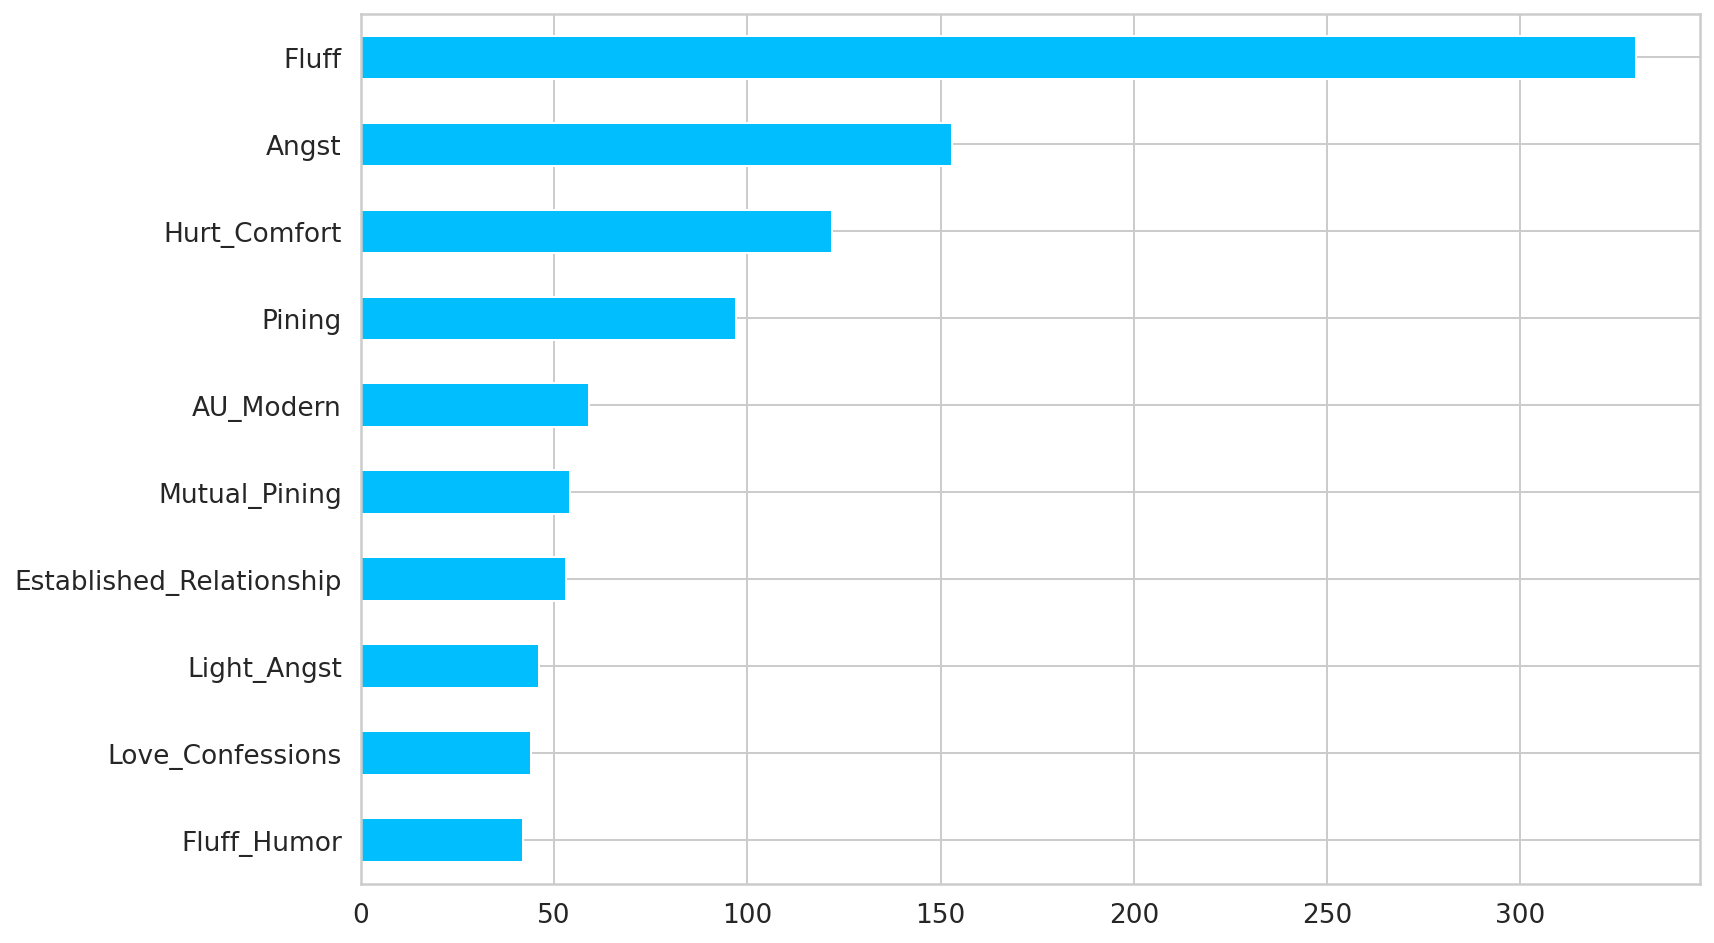

In [ ]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

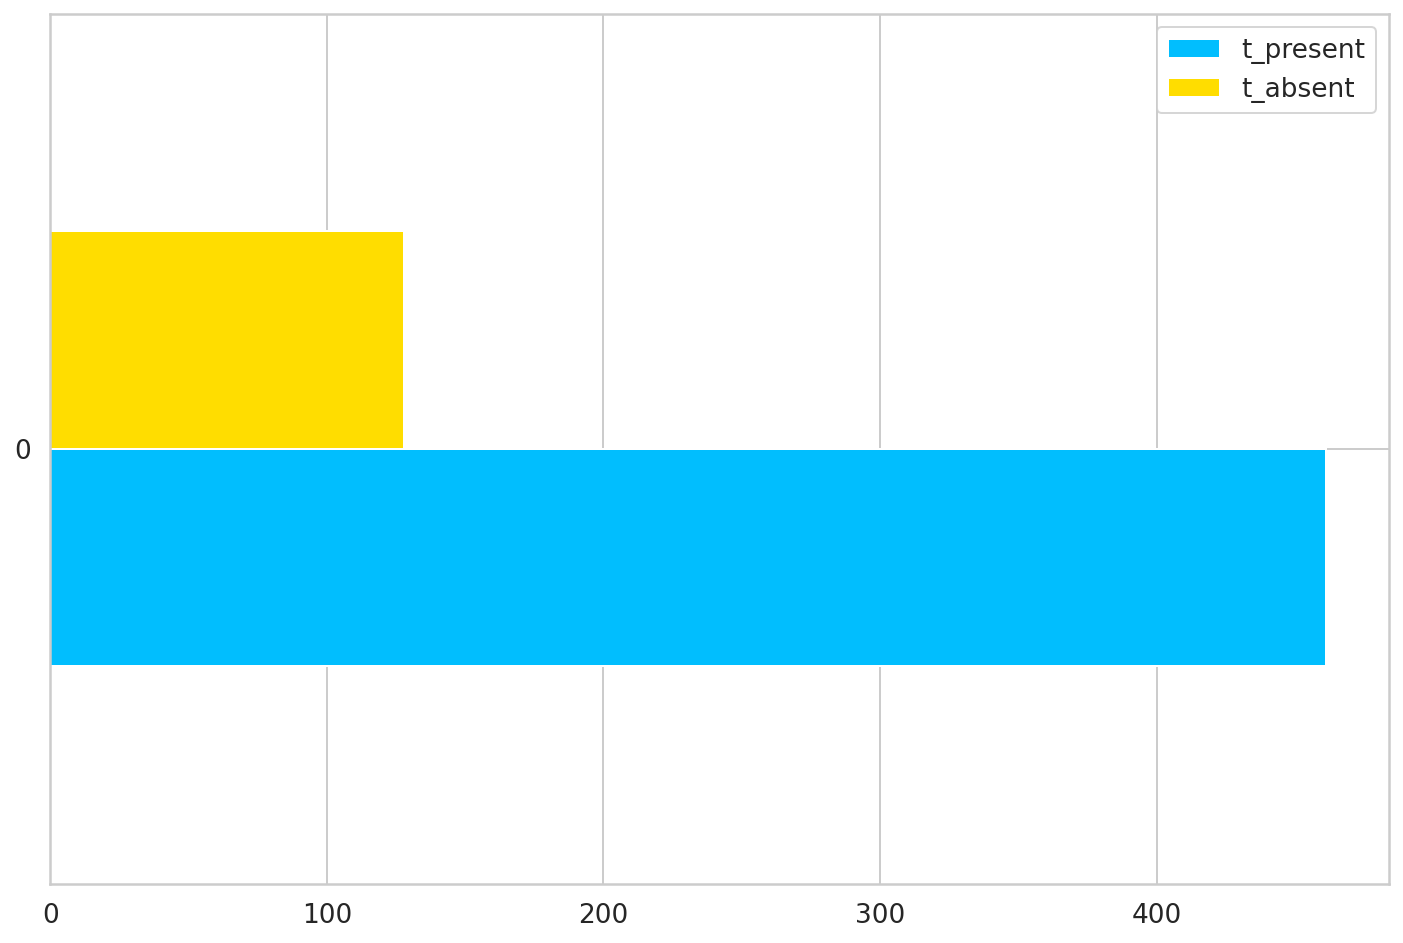

In [ ]:
train_tags_present = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_tags_absent = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  t_present=[len(train_tags_present)], 
  t_absent=[len(train_tags_absent)]
)).plot(kind='barh');

In [ ]:
train_df = pd.concat([
  train_tags_present.sample(150),
  train_tags_absent
])

train_df.shape, val_df.shape

((278, 12), (31, 12))

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sample_row = df.iloc[16]
sample_comment = sample_row.body
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

There was Harbinger in his fucking city. In his bar, to be specific - sitting across from him nursing his fourth glass of Fontaine-imported golden champagne with a dopey smile on his face. He couldn't even ask for a flute like a civilized person, he had specifically requested a fat square glass and started pouring.

"This is pretty good," Childe slurred, picking up the glass with one languid hand and swirling the wine obnoxiously. "Hey. You should serve at my wedding."

Why was he talking to him. Diluc plastered a friendly smile to his face and said, "Don't you think you've had enough for tonight?"

"Ha! I said it was good, not that it was strong. If Mondstadtian wine is a candle, then Snezhnayan firewater is the sun. My folks, where I'm from, they'd laugh themselves silly if I couldn't handle a bit of shiny piss-looking liquid like this. Do you want to see my ring?"

No. "Sir, you've already shown me your ring seventeen - "

"It's beautiful, isn't it?" said Childe dreamily, sticking h

In [ ]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [ ]:
encoding["input_ids"].squeeze()[:20]

tensor([  101,  1247,  1108, 11679, 26281,  7728,  1107,  1117,  8750,  1331,
          119,  1130,  1117,  2927,   117,  1106,  1129,  2747,   118,  2807])

In [ ]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze()))

['[CLS]', 'There', 'was', 'Ha', '##rb', '##inger', 'in', 'his', 'fucking', 'city', '.', 'In', 'his', 'bar', ',', 'to', 'be', 'specific', '-', 'sitting', 'across', 'from', 'him', 'nursing', 'his', 'fourth', 'glass', 'of', 'F', '##ontaine', '-', 'imported', 'golden', 'champagne', 'with', 'a', 'do', '##pe', '##y', 'smile', 'on', 'his', 'face', '.', 'He', 'couldn', "'", 't', 'even', 'ask', 'for', 'a', 'flute', 'like', 'a', 'civil', '##ized', 'person', ',', 'he', 'had', 'specifically', 'requested', 'a', 'fat', 'square', 'glass', 'and', 'started', 'pouring', '.', '"', 'This', 'is', 'pretty', 'good', ',', '"', 'Child', '##e', 's', '##lu', '##rred', ',', 'picking', 'up', 'the', 'glass', 'with', 'one', 'la', '##ng', '##uid', 'hand', 'and', 'swirling', 'the', 'wine', 'o', '##b', '##no', '##xious', '##ly', '.', '"', 'Hey', '.', 'You', 'should', 'serve', 'at', 'my', 'wedding', '.', '"', 'Why', 'was', 'he', 'talking', 'to', 'him', '.', 'Di', '##lu', '##c', 'plastered', 'a', 'friendly', 'smile', 'to

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["body"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

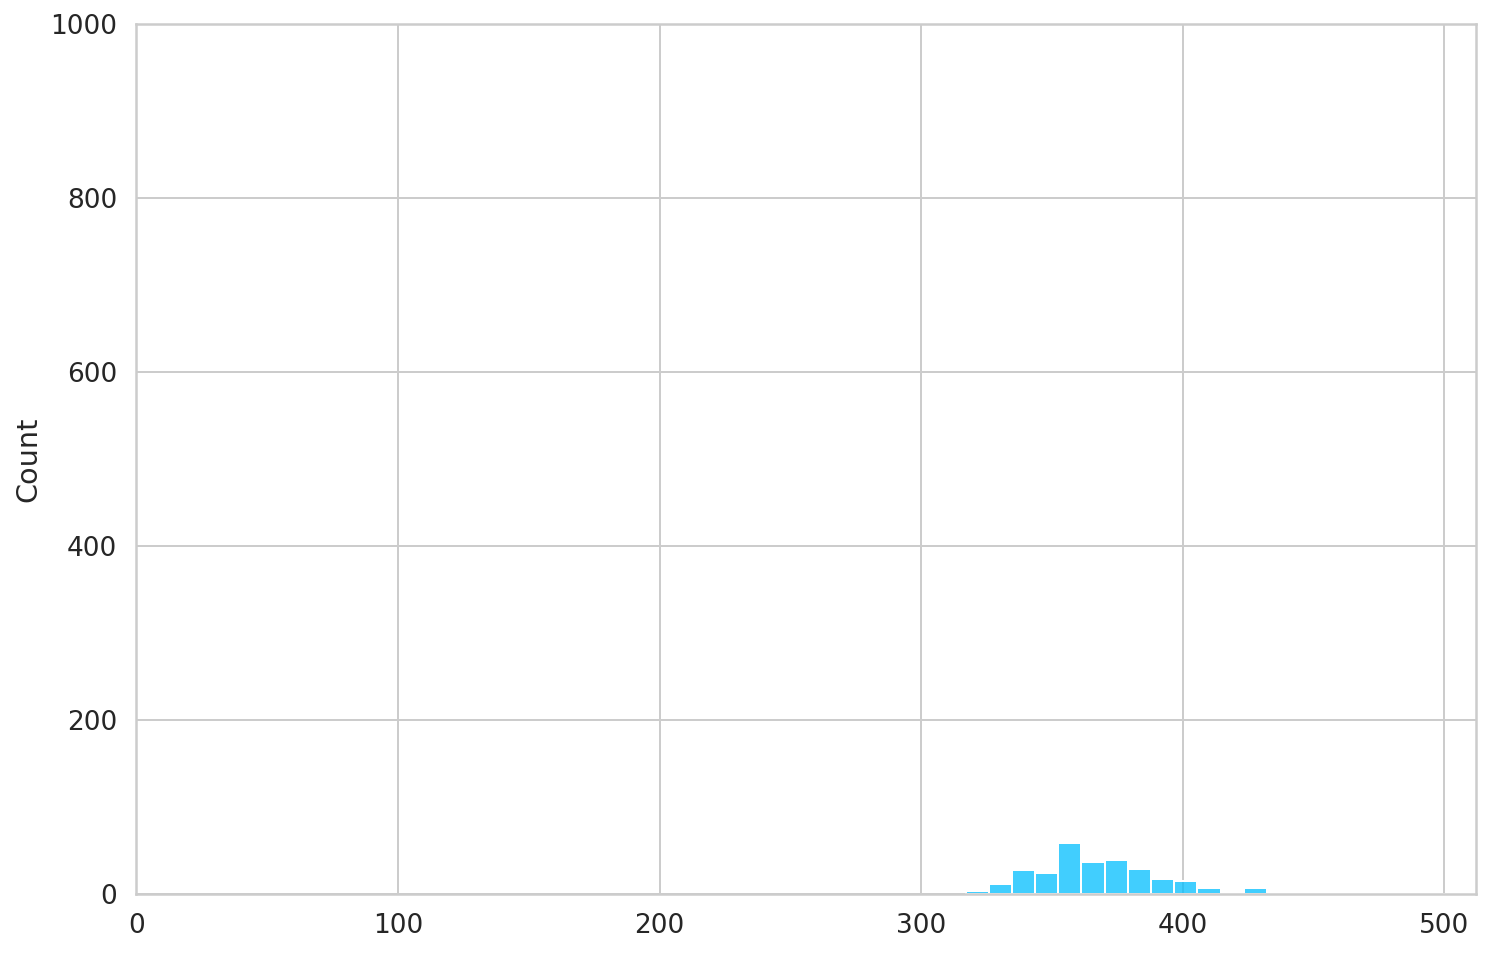

In [ ]:
sns.histplot(token_counts)
plt.xlim([0, 512]);
plt.ylim([0, 1000]);

In [ ]:
MAX_TOKEN_COUNT = 512

In [ ]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    body = data_row.body
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      body,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      body=body,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['body', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
sample_item["body"]

'Xiao looked down at the bottle of wine in his hands. He read over the label; it was definitely from Fontaine, and it was definitely really expensive.\n\nHe looked back up at Zhongli, who\'d come to visit him at Wangshu Inn, "Why did you give this to me, again?" He raised an eyebrow. Morax knew that Xiao wasn\'t one for drinking; it was a human activity, something to keep them occupied during their short existence. But who was Xiao to refuse a gift from his god?\n\nHis god merely shrugged, "I was given too much, and it would be a shame to have to waste something as fine as this. I figured you would be able to find a use for it, even if it\'s not to drink it yourself. You could perhaps give it to Smiley Yanxiao for him to include in his cooking, or... Oh, I don\'t know, gift it to someone else." Morax got a knowing look on his face, one with softened eyes and a very slight smile. Xiao only narrowed his eyes at the look. "Well, I have to be off now. I suggest you be off as well." And wit

In [ ]:
sample_item["labels"]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
sample_item["input_ids"].shape

torch.Size([512])

In [ ]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [ ]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [ ]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
class ToxicCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
class ToxicCommentTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [ ]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


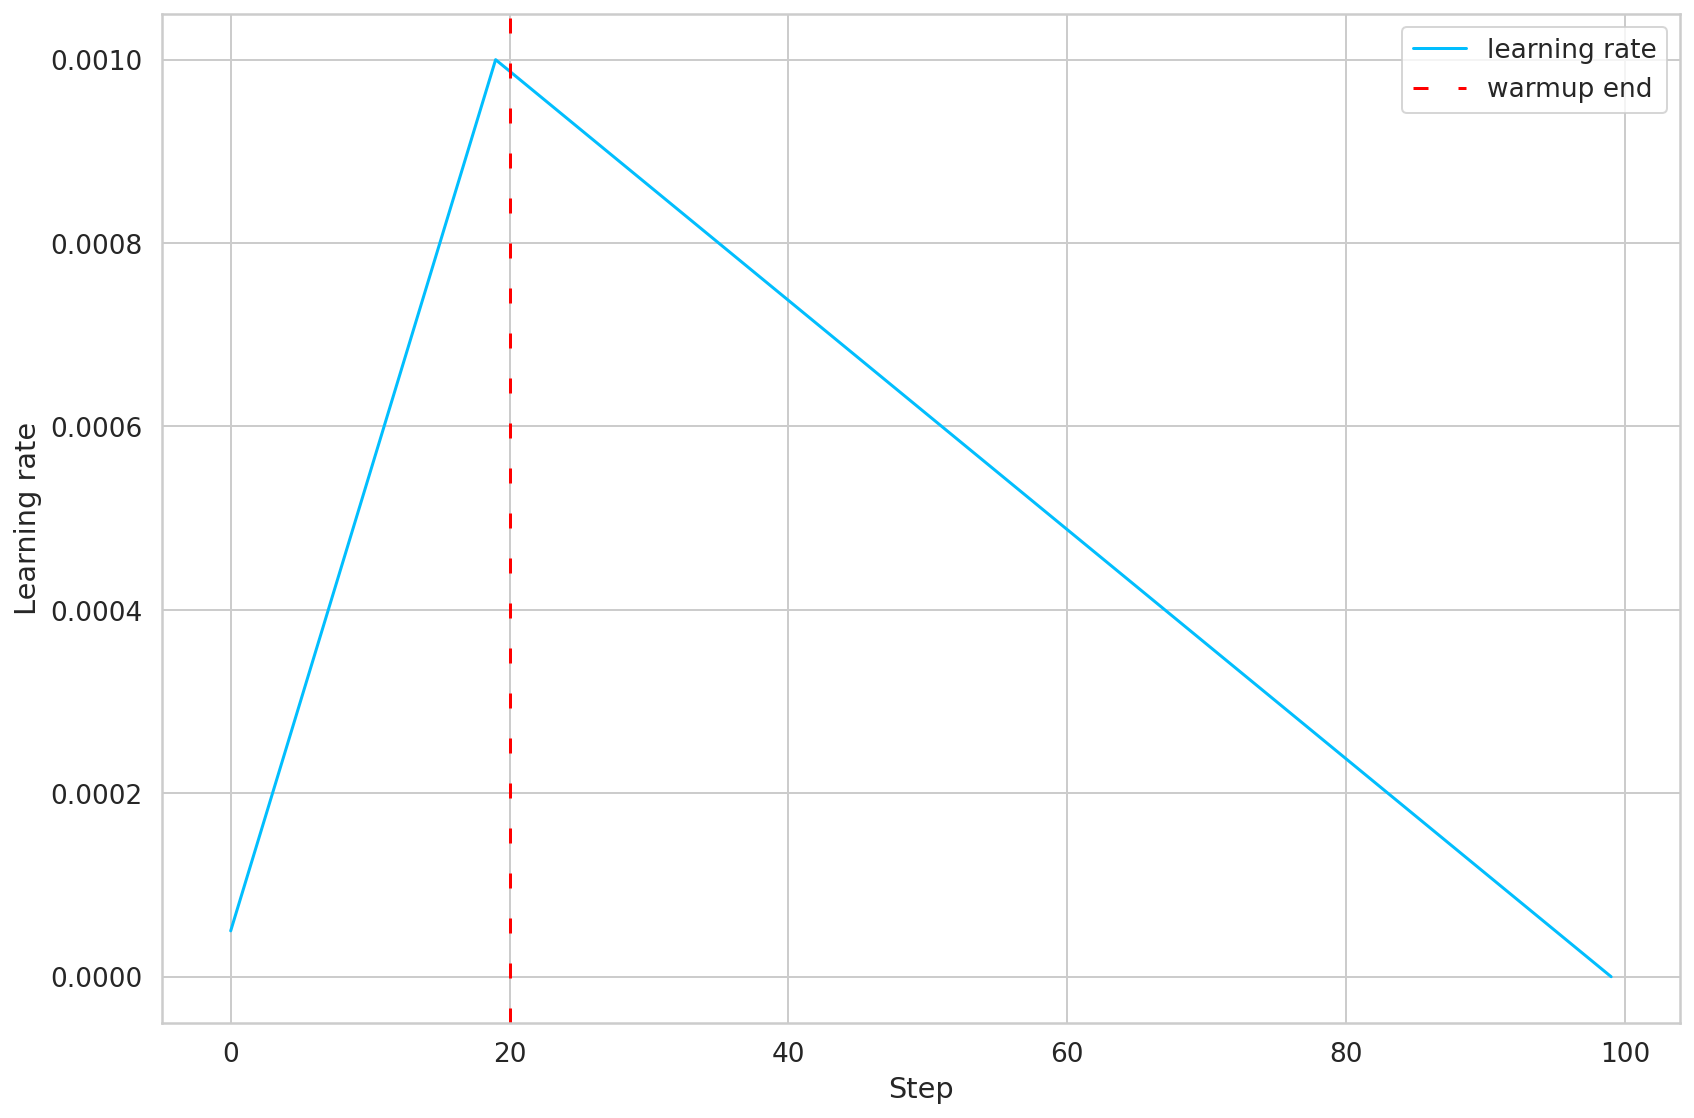

In [ ]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(46, 230)

In [ ]:
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
criterion = nn.BCELoss()

prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
) 

In [ ]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [ ]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

In [ ]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.5635, 0.5538, 0.3219, 0.3743, 0.4432, 0.5510, 0.4562, 0.3892, 0.4382,
         0.3668],
        [0.5466, 0.5404, 0.3385, 0.4017, 0.4428, 0.5368, 0.4624, 0.4067, 0.4487,
         0.3644],
        [0.5468, 0.5268, 0.3584, 0.3909, 0.4828, 0.5173, 0.4369, 0.4122, 0.4575,
         0.3562],
        [0.5649, 0.5488, 0.3452, 0.4000, 0.4290, 0.5532, 0.4338, 0.4076, 0.4375,
         0.3736],
        [0.5658, 0.5552, 0.3485, 0.3794, 0.4409, 0.5547, 0.4178, 0.4095, 0.4331,
         0.3594],
        [0.5769, 0.5550, 0.3408, 0.3857, 0.4284, 0.5559, 0.4180, 0.4141, 0.4308,
         0.3550],
        [0.5222, 0.5247, 0.3570, 0.4028, 0.4628, 0.5288, 0.4594, 0.4134, 0.4643,
         0.3693],
        [0.5590, 0.5295, 0.3495, 0.3911, 0.4712, 0.5309, 0.4266, 0.4246, 0.4486,
         0.3867]], grad_fn=<SigmoidBackward0>)

In [ ]:
criterion(predictions, sample_batch["labels"])

tensor(0.6290, grad_fn=<BinaryCrossEntropyBackward0>)

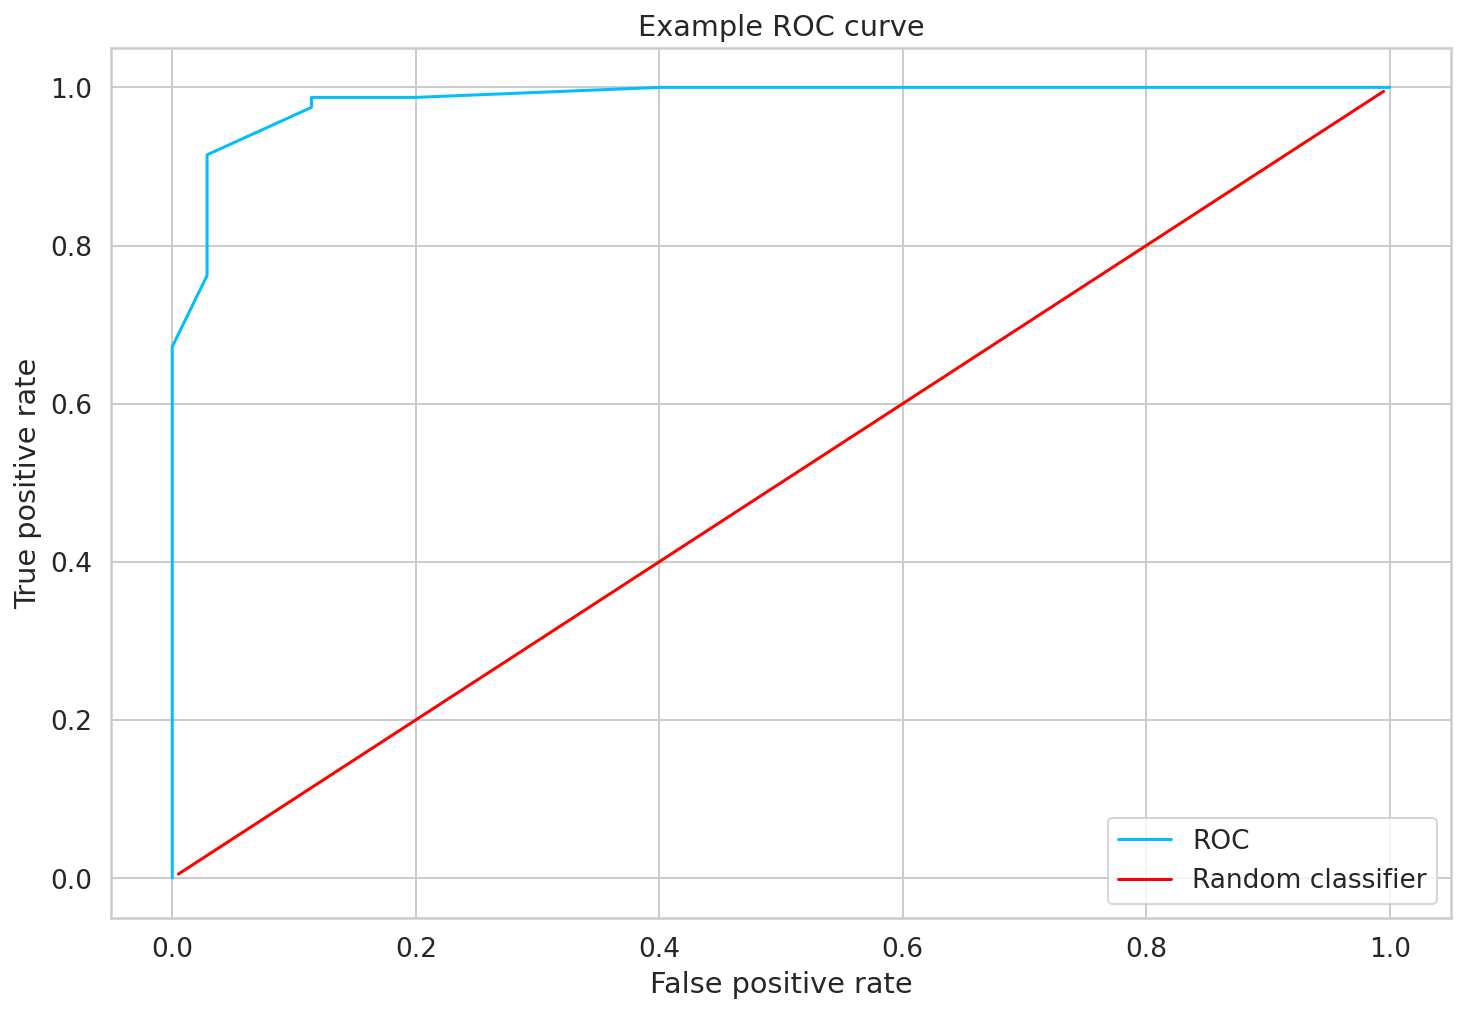

In [ ]:
from sklearn import metrics

fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]

tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

In [ ]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

<IPython.core.display.Javascript object>

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4)

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

MisconfigurationException: ignored